This script checks if regulons have consistent expression.

The steps are the following:
* iterate over regulons.
* plot row expression.
* plot the log2 expression.
* scale the data. Consider z-scores and real scaling within a defined range.
* run PCA. Check how much variance is explained by PC1. This is the key to accept regulon tightness.
* use scores as values for heatmap.
* optionally, check the correlation of TF and PC1 to reveal if the TF is transcriptionally or posttranscriptionally regulated, e.g., phosphorylation.

In [1]:
import pandas, numpy

In [2]:
import scipy, scipy.stats
import sklearn, sklearn.decomposition

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20})

In [4]:
import pyensembl
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

# 0. user-defined variables

In [5]:
regulon_input_file = '/home/adrian/projects/osteo/results/grn/regulons.txt'
expression_data_input_file = '/home/adrian/projects/osteo/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/projects/osteo/metadata/MSC_Sample list.csv'
DETs_input_file = '/home/adrian/projects/osteo/results/DETs_filtered/entire_DET_set.txt'

In [6]:
donors = ['6', '16', '17']
days = ['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']

# 1. read data

## 1.1. read regulon memberships

In [7]:
df = pandas.read_csv(regulon_input_file, sep='\t', index_col=0)
df.head()

,TF targets DEGs / all TF targets,background DEG rank / background TF targets rank,Targets fold-enrichment,Uncorrected hypergeometric P value,Adjusted P value (BH; alpha=0.1),Observed TF target DEGs
TF,,,,,,
KLF16,59/799,1089/20300,1.376491,8.068623e-03,7.106365e-02,"NECTIN1, DDIT4, PAFAH1B3, NOP2, PRKAR1B, CILP2..."
E2F8,186/740,1089/20300,4.685429,2.279433e-75,2.710246e-72,"NECTIN1, PDE1A, UHRF1, EXO1, SPC25, RRM2, BLM,..."
ZNF750,47/495,1089/20300,1.769949,1.095739e-04,1.714255e-03,"NECTIN1, DOCK10, ST3GAL5, MCC, NRCAM, MYO1B, M..."
HIVEP3,25/192,1089/20300,2.427208,3.699457e-05,6.283792e-04,"NECTIN1, UHRF1, NOP2, PPRC1, CILP2, QSOX2, IL1..."
GATA5,44/516,1089/20300,1.589539,1.676692e-03,1.812352e-02,"C1QTNF6, NCAPG, TNFRSF19, GNB3, EFEMP1, CFD, C..."


## 1.2. read expression data

In [8]:
def metadata_reader():

    metadata = {}
    donors = []
    days = []

    with open(metadata_file, 'r') as f:
        next(f)
        for line in f:
            v = line.split(',')
            sample = v[0]
            day = v[-2]
            donor = v[-3]
            metadata[sample] = (donor, day)

            if donor not in donors:
                donors.append(donor)
            if day not in days:
                days.append(day)

    return metadata, donors, days

In [9]:
metadata, donors, days = metadata_reader()
print(days)

['Day_3', 'Day_6', 'Day_9', 'Day_16', 'Day_28']


In [10]:
expression = {}
ensembl_IDs = []

for sample in metadata:
    expression[sample] = {}

with open(expression_data_input_file, 'r') as f:

    header = f.readline()
    v = header.split('\t')
    sample_IDs = v[1:]
    sample_IDs[-1] = sample_IDs[-1].replace('\n', '')

    for line in f:
        v = line.split('\t')

        gene_name = v[0]
        ensembl_IDs.append(gene_name)
        v = [float(element) for element in v[1:]]

        for i in range(len(v)):
            value = v[i]
            sampleID = sample_IDs[i]
            expression[sampleID][gene_name] = value

In [11]:
###
### Let's work with expression trajectories for only the genes we care: DETs and TFs
###

# retrieve DETs for expression
DETs = []
with open(DETs_input_file, 'r') as f:
    for line in f:
        element = line.replace('\n', '')
        DETs.append(element)
print('DETs found: {}'.format(len(DETs)))
print(len(list(set(DETs))))

# add TFs, in case we work with their expression later
TFs = df.index.to_list()
print(len(TFs), TFs[:10])
TF_ensembl_ids = [annotation.gene_ids_of_gene_name(TF)[0] for TF in TFs]
print(len(TF_ensembl_ids), TF_ensembl_ids)

working_genes = list(set(DETs + TF_ensembl_ids))

print(len(working_genes))

DETs found: 1106
1106
139 ['KLF16', 'E2F8', 'ZNF750', 'HIVEP3', 'GATA5', 'FOXS1', 'IRF5', 'TBX2', 'TRERF1', 'PKNOX2']
139 ['ENSG00000129911', 'ENSG00000129173', 'ENSG00000141579', 'ENSG00000127124', 'ENSG00000130700', 'ENSG00000179772', 'ENSG00000128604', 'ENSG00000121068', 'ENSG00000124496', 'ENSG00000165495', 'ENSG00000182463', 'ENSG00000169946', 'ENSG00000106511', 'ENSG00000185591', 'ENSG00000121297', 'ENSG00000177606', 'ENSG00000176692', 'ENSG00000118526', 'ENSG00000152784', 'ENSG00000151322', 'ENSG00000163132', 'ENSG00000167157', 'ENSG00000152284', 'ENSG00000174332', 'ENSG00000124813', 'ENSG00000126603', 'ENSG00000107249', 'ENSG00000120738', 'ENSG00000109320', 'ENSG00000171056', 'ENSG00000116132', 'ENSG00000149054', 'ENSG00000150347', 'ENSG00000140044', 'ENSG00000198795', 'ENSG00000147862', 'ENSG00000177426', 'ENSG00000120693', 'ENSG00000105967', 'ENSG00000115112', 'ENSG00000091831', 'ENSG00000112837', 'ENSG00000163884', 'ENSG00000061455', 'ENSG00000053254', 'ENSG00000108001', 'EN

In [12]:
# we will work from this point with gene symbols only, converting ENSEMBL to gene symbols
manual_annotation = {
    'ENSG00000274619':'CFD',
    'ENSG00000278843':'MMP28',
    'ENSG00000227746':'C4A',
    'ENSG00000282854':'ASAP3',
    'ENSG00000283009':'ZNF436',
    'ENSG00000283106':'ZNF436-AS1',
    'ENSG00000263238':'CTSO',
    'ENSG00000275482':'EPHB6',
    'ENSG00000262862':'KRTAP2-3',
    'ENSG00000277909':'SPC25',
    'ENSG00000281166':'NLRP10',
    'ENSG00000280610':'KIF15',
    'ENSG00000280682':'HYOU1',
    'ENSG00000280641':'CDH4',
    'ENSG00000273707':'CDKN1C',
    'ENSG00000233450':'KIFC1',
    'ENSG00000262634':'SKA1',
    'ENSG00000275125':'PRXL2B',
    'ENSG00000281165':'SLC2A6',
    'ENSG00000276657':'PYCR3',
    'ENSG00000282147':'FAM20C'
}

In [13]:
# convert ensembl to gene symbol
for working_gene in working_genes:
    
    # convert ensembl to gene symbol
    try:
        name = annotation.gene_name_of_gene_id(working_gene)
    except:
        print('Ensembl ID {} not found in annotation.'.format(working_gene))
        if working_gene in manual_annotation:
            name = manual_annotation[working_gene]
            print('\t present in manual annotation, all OK.')
        else:
            print('WE HAVE A PROBLEM')
        print()

Ensembl ID ENSG00000262862 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000273707 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000263238 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000281166 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000280641 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000281165 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000282854 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000277909 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000282147 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000276657 not found in annotation.
	 present in manual annotation, all OK.

Ensembl ID ENSG00000233450 not found in annotation.
	 present in manua

In [14]:
# obtain a TPM trajectory (discrete for very low) across time over replicates and patients
expression_trajectories = {}

for working_gene in working_genes:
    
    # convert ensembl to gene symbol
    try:
        name = annotation.gene_name_of_gene_id(working_gene)
    except:
        print('Ensembl ID {} not found in annotation.'.format(working_gene))
        if working_gene in manual_annotation:
            name = manual_annotation[working_gene]
            print('\t present in manual annotation, all OK.')
        else:
            print('WE HAVE A PROBLEM')
    ############################
    
    ensembl_trajectory = []
    for day in days:
        expression_across_donors = []
        for donor in donors:
            
            # retrieve sample labels
            sample_labels = []
            for sample in sample_IDs:
                if metadata[sample] == (donor, day):
                    sample_labels.append(sample)
            
            # retrieve expression
            try:
                exp = [expression[label][working_gene] for label in sample_labels]
            except:
                exp = [0 for label in sample_labels]
                print('ENSEMBL ID {} not found in expression data set. Setting expression to zero.'.format(working_gene))
                    
            average_expression = numpy.mean(exp)
            if numpy.isnan(average_expression) == False:
                expression_across_donors.append(average_expression)
                
        # compute median across patients
        median_expression = numpy.median(expression_across_donors)
        
        # round values, useful for very low values
        round_value = numpy.around(median_expression) + 1
        
        # add round value to trajectory
        ensembl_trajectory.append(round_value)
    
    # add trajectory to dictionary
    expression_trajectories[name] = ensembl_trajectory
    
    print(name, ensembl_trajectory)

HEYL [1.0, 1.0, 1.0, 1.0, 1.0]
PF4 [5.0, 6.0, 8.0, 28.0, 9.0]
CLCA2 [1.0, 1.0, 4.0, 4.0, 5.0]
C1S [56.0, 168.0, 229.0, 137.0, 300.0]
APOL1 [8.0, 20.0, 20.0, 16.0, 24.0]
ZNF469 [7.0, 4.0, 3.0, 3.0, 2.0]
PTH1R [1.0, 1.0, 3.0, 1.0, 7.0]
SPX [1.0, 2.0, 2.0, 4.0, 3.0]
GAS1 [27.0, 75.0, 120.0, 126.0, 197.0]
KIF26B [2.0, 3.0, 9.0, 5.0, 8.0]
OIP5 [8.0, 4.0, 2.0, 3.0, 2.0]
FBLN5 [557.0, 362.0, 162.0, 98.0, 69.0]
MTMR9LP [4.0, 7.0, 4.0, 2.0, 1.0]
COL4A4 [1.0, 3.0, 5.0, 2.0, 11.0]
CTD-2589M5.5 [3.0, 2.0, 1.0, 2.0, 1.0]
C1R [22.0, 106.0, 205.0, 89.0, 142.0]
MME [200.0, 556.0, 537.0, 491.0, 1141.0]
RHOQ [25.0, 38.0, 45.0, 45.0, 119.0]
SGO2 [12.0, 6.0, 4.0, 7.0, 3.0]
GATA5 [1.0, 1.0, 1.0, 1.0, 1.0]
TROAP [18.0, 7.0, 3.0, 6.0, 2.0]
DKK2 [5.0, 3.0, 2.0, 3.0, 3.0]
DEPDC1 [8.0, 4.0, 1.0, 4.0, 1.0]
FAM83G [6.0, 3.0, 2.0, 4.0, 2.0]
TRPS1 [8.0, 6.0, 7.0, 6.0, 6.0]
WDR76 [8.0, 4.0, 3.0, 3.0, 3.0]
TXNIP [56.0, 382.0, 576.0, 520.0, 660.0]
RAC2 [16.0, 14.0, 8.0, 13.0, 3.0]
ENPP4 [3.0, 5.0, 5.0, 7.0, 30.0]
ZNF9

/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ensembl ID ENSG00000281166 not found in annotation.
	 present in manual annotation, all OK.
NLRP10 [3.0, 3.0, 1.0, 2.0, 2.0]
RARRES3 [2.0, 10.0, 16.0, 9.0, 10.0]
Ensembl ID ENSG00000280641 not found in annotation.
	 present in manual annotation, all OK.
CDH4 [6.0, 4.0, 2.0, 3.0, 3.0]
CD82 [31.0, 68.0, 118.0, 83.0, 153.0]
GPNMB [18.0, 18.0, 57.0, 35.0, 67.0]
SDF2L1 [44.0, 15.0, 10.0, 23.0, 11.0]
SLC22A15 [6.0, 6.0, 8.0, 7.0, 17.0]
CDC6 [6.0, 2.0, 1.0, 2.0, 1.0]
CD24 [2.0, 5.0, 5.0, 2.0, 4.0]
METTL7B [7.0, 4.0, 2.0, 3.0, 2.0]
CCDC85C [4.0, 3.0, 2.0, 2.0, 2.0]
CYCS [97.0, 47.0, 33.0, 75.0, 32.0]
CDKN1C [1.0, 3.0, 4.0, 1.0, 17.0]
IGF2 [15.0, 306.0, 652.0, 428.0, 1031.0]
EPS8 [28.0, 45.0, 43.0, 33.0, 91.0]
RAD51 [11.0, 4.0, 3.0, 4.0, 2.0]
RP11-221N13.3 [21.0, 16.0, 3.0, 23.0, 12.0]
RAD54L [8.0, 3.0, 2.0, 3.0, 2.0]
RP11-351M8.1 [7.0, 40.0, 41.0, 7.0, 34.0]
GALNT6 [18.0, 10.0, 4.0, 6.0, 2.0]
CPED1 [11.0, 9.0, 3.0, 5.0, 7.0]
PRG4 [1.0, 3.0, 2.0, 4.0, 20.0]
LINC01503 [6.0, 17.0, 25.0, 9.0, 13.0

CDCA7 [9.0, 4.0, 4.0, 5.0, 2.0]
SLC8A1 [14.0, 7.0, 5.0, 8.0, 4.0]
E2F8 [3.0, 1.0, 1.0, 1.0, 1.0]
MEST [4.0, 25.0, 39.0, 16.0, 15.0]
MKX [1.0, 2.0, 1.0, 2.0, 2.0]
EIF4EBP3 [4.0, 6.0, 11.0, 10.0, 15.0]
EPHB2 [9.0, 5.0, 5.0, 5.0, 3.0]
PAPPA [5.0, 13.0, 15.0, 28.0, 47.0]
VEPH1 [27.0, 15.0, 13.0, 15.0, 6.0]
RP11-575F12.2 [2.0, 3.0, 4.0, 7.0, 47.0]
NUSAP1 [23.0, 10.0, 5.0, 11.0, 3.0]
TLE6 [1.0, 4.0, 3.0, 2.0, 7.0]
TMEM100 [5.0, 8.0, 15.0, 22.0, 27.0]
CXXC4 [1.0, 1.0, 1.0, 1.0, 1.0]
KIF15 [4.0, 2.0, 1.0, 2.0, 1.0]
VMO1 [1.0, 3.0, 7.0, 20.0, 16.0]
DAPK1 [3.0, 14.0, 5.0, 3.0, 5.0]
E2F7 [4.0, 2.0, 2.0, 2.0, 1.0]
CLSPN [9.0, 2.0, 2.0, 2.0, 1.0]
ST3GAL5 [3.0, 4.0, 6.0, 5.0, 17.0]
BLM [4.0, 2.0, 1.0, 2.0, 1.0]
CORIN [10.0, 13.0, 17.0, 7.0, 46.0]
APOB [1.0, 5.0, 6.0, 2.0, 5.0]
MYLIP [1.0, 3.0, 4.0, 3.0, 4.0]
GALNT15 [4.0, 47.0, 21.0, 25.0, 178.0]
PRDM6 [1.0, 2.0, 2.0, 1.0, 1.0]
TIMELESS [11.0, 6.0, 4.0, 7.0, 3.0]
BOC [9.0, 11.0, 21.0, 20.0, 30.0]
RP11-94A24.1 [15.0, 69.0, 86.0, 102.0, 154.0]
HMGA2 [

CCDC68 [12.0, 16.0, 20.0, 20.0, 72.0]
NEK2 [9.0, 4.0, 2.0, 4.0, 2.0]
NF2 [40.0, 19.0, 14.0, 19.0, 11.0]
EZH2 [12.0, 5.0, 5.0, 4.0, 3.0]
APOL3 [3.0, 12.0, 12.0, 8.0, 6.0]
TNFSF10 [1.0, 3.0, 4.0, 2.0, 2.0]
GLTSCR2 [69.0, 132.0, 241.0, 183.0, 255.0]
CENPM [13.0, 5.0, 3.0, 5.0, 2.0]
AC007246.3 [18.0, 29.0, 31.0, 31.0, 59.0]
NRCAM [7.0, 12.0, 19.0, 15.0, 52.0]
RTN4RL1 [1.0, 2.0, 3.0, 2.0, 2.0]
FAM134B [1.0, 2.0, 5.0, 4.0, 15.0]
RASSF7 [6.0, 3.0, 2.0, 1.0, 1.0]
PRDM8 [6.0, 8.0, 8.0, 7.0, 6.0]
PTPRF [36.0, 18.0, 12.0, 8.0, 6.0]
TM4SF20 [2.0, 5.0, 5.0, 2.0, 6.0]
SPRED3 [14.0, 10.0, 7.0, 10.0, 4.0]
NCLN [68.0, 32.0, 28.0, 52.0, 17.0]
NR1H3 [7.0, 16.0, 20.0, 22.0, 17.0]
AC004538.3 [4.0, 9.0, 14.0, 8.0, 17.0]
SMOC1 [4.0, 12.0, 20.0, 20.0, 36.0]
GINS2 [6.0, 2.0, 1.0, 3.0, 1.0]
ASPM [8.0, 4.0, 2.0, 3.0, 1.0]
CDCA2 [8.0, 3.0, 2.0, 3.0, 2.0]
RNU6-403P [2.0, 3.0, 4.0, 4.0, 47.0]
REPS2 [3.0, 8.0, 11.0, 13.0, 22.0]
MBNL2 [13.0, 21.0, 19.0, 20.0, 43.0]
RP11-123O22.1 [15.0, 4.0, 2.0, 3.0, 1.0]
TGFBI [930.

WISP1 [38.0, 33.0, 103.0, 134.0, 138.0]
PLSCR1 [28.0, 59.0, 71.0, 62.0, 104.0]
SLC9A9 [2.0, 5.0, 5.0, 5.0, 6.0]
ZNF92 [5.0, 5.0, 4.0, 4.0, 3.0]
NMNAT2 [5.0, 8.0, 6.0, 17.0, 9.0]
ZFHX3 [11.0, 10.0, 8.0, 9.0, 9.0]
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting expression to zero.
ENSEMBL ID ENSG00000183770 not found in expression data set. Setting express

# 2. analysis

In [15]:
time_trajectory = [int(day.split('_')[-1]) for day in days]
print(time_trajectory)
theColors = ['blue', 'green', 'gold', 'orange', 'red']
print(theColors)

[3, 6, 9, 16, 28]
['blue', 'green', 'gold', 'orange', 'red']


In [41]:
from sklearn.cluster import OPTICS, AgglomerativeClustering

KLF16 59
['NECTIN1', 'DDIT4', 'PAFAH1B3', 'NOP2', 'PRKAR1B', 'CILP2', 'PPRC1', 'C21orf58', 'FOXC2', 'CD3EAP', 'RANGAP1', 'UBE2S', 'FAM167A', 'RASSF7', 'SHB', 'ADAMTS10', 'CDKN1A', 'TUBB2B', 'SH3BP1', 'LMNB1', 'PNP', 'FOSL1', 'FJX1', 'C11orf91', 'DEPTOR', 'PIK3R1', 'SESN1', 'PRXL2B', 'GCH1', 'TNFRSF10D', 'NOP56', 'KIF15', 'SDF2L1', 'ANTXR2', 'LMCD1', 'TUBB3', 'PNRC1', 'WASL', 'S100A16', 'CTXN1', 'CRISPLD2', 'CDCA3', 'EEPD1', 'LRRC32', 'TUBB4B', 'CCDC86', 'VGLL4', 'DCBLD2', 'ABHD4', 'FBXO32', 'NCLN', 'SLC25A10', 'FAM89A', 'RHBDF2', 'ASAP3', 'HMGA1', 'LIFR', 'SEMA7A', 'PSD4']


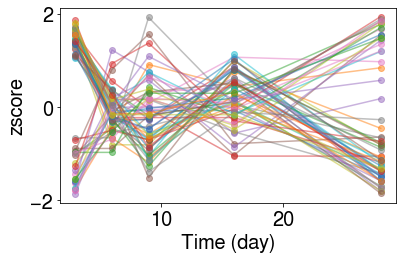

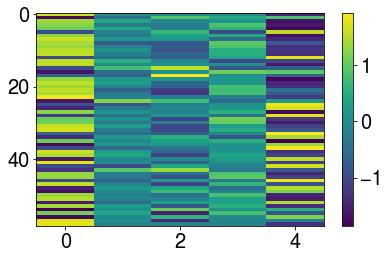

[1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0
 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1]


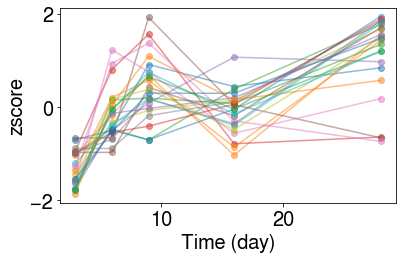

VARIANCE EXPLAINED: [0.78776051 0.12869169]


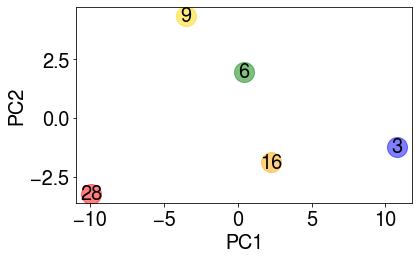

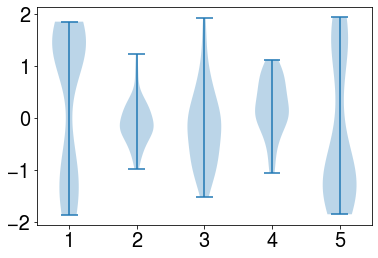

E2F8 186
['NECTIN1', 'PDE1A', 'UHRF1', 'EXO1', 'SPC25', 'RRM2', 'BLM', 'PASK', 'WDR62', 'CDKN1A', 'CDC20', 'CCNB2', 'SHCBP1', 'BUB1B', 'ABCA13', 'IQGAP3', 'TRIP13', 'RACGAP1', 'KIF2C', 'ARHGAP11B', 'VRK1', 'KIF15', 'ORC6', 'TTK', 'DBF4', 'CHAF1A', 'AURKB', 'SKA3', 'SAPCD2', 'DTL', 'PBK', 'FAM83D', 'KNL1', 'CCNB1', 'CDKN3', 'MFGE8', 'TCF19', 'KIF20A', 'KIF18B', 'TROAP', 'GINS1', 'KIFC1', 'AURKA', 'MCM2', 'BUB1', 'NOG', 'CCNF', 'CHAF1B', 'E2F1', 'MCM10', 'ARHGAP11A', 'LMNB1', 'FERMT1', 'ESPL1', 'HMMR', 'CSTA', 'RRM1', 'PLAC8', 'PLK4', 'GALNT6', 'MAD2L1', 'RAD51AP1', 'GINS4', 'PRIM1', 'PIF1', 'DEPDC1B', 'STIL', 'SMC2', 'CDC6', 'SPAG5', 'NCAPG2', 'CDCP1', 'GTSE1', 'CDK1', 'DEPDC1', 'INCENP', 'RAB27B', 'DLGAP5', 'CENPK', 'CEP55', 'MLPH', 'RAD54L', 'TPM3', 'SGO1', 'CDC45', 'MTFR2', 'PDGFRA', 'HMGA1', 'BIRC5', 'ORC1', 'CENPM', 'FIGNL1', 'MELK', 'ESCO2', 'CIT', 'KIF23', 'GINS2', 'TK1', 'FANCA', 'SGO2', 'MCM5', 'PLXDC2', 'ZNF367', 'ZWINT', 'POLQ', 'CKS2', 'SLC12A8', 'PAQR4', 'FAM111B', 'PTTG1',

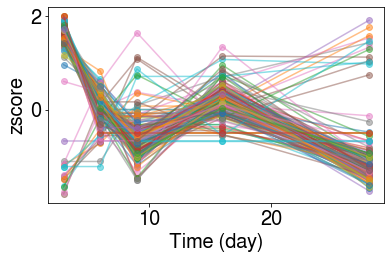

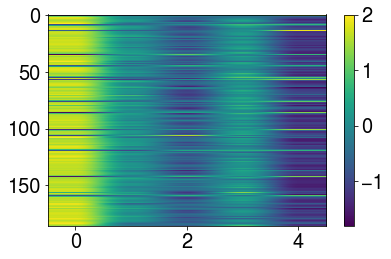

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


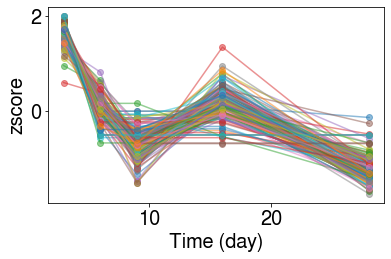

VARIANCE EXPLAINED: [0.9124143  0.04193107]


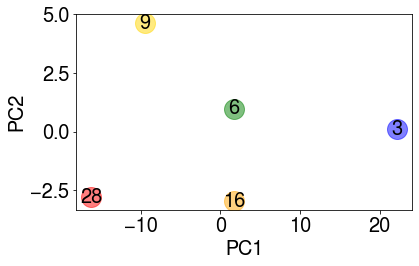

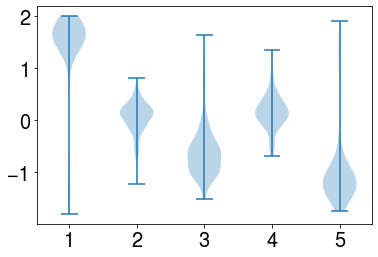

ZNF750 47
['NECTIN1', 'DOCK10', 'ST3GAL5', 'MCC', 'NRCAM', 'MYO1B', 'MME', 'UBASH3B', 'SYNJ2', 'LINC00598', 'ABCA13', 'KCNMA1', 'MYO1D', 'SLC8A1', 'ST6GAL1', 'DAPK2', 'EPAS1', 'FBLN1', 'NFATC2', 'NEDD9', 'PFKP', 'LINC00578', 'TNC', 'PAPPA', 'CRISPLD2', 'TENM2', 'KLF9', 'SLIT3', 'PTK2B', 'HTRA1', 'NTM', 'ZBTB16', 'TIAM1', 'MTSS1', 'LSAMP', 'TGFBR3', 'CD82', 'SLC44A1', 'PTPRF', 'MYLK', 'KIAA1217', 'NABP1', 'MAOA', 'COL21A1', 'CSMD2', 'TPD52L1', 'STIM1']


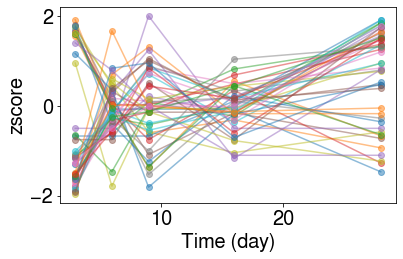

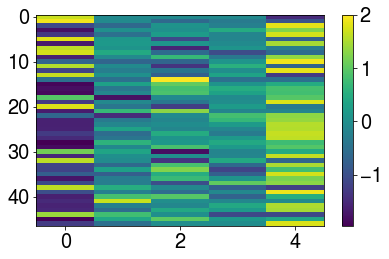

[1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0]


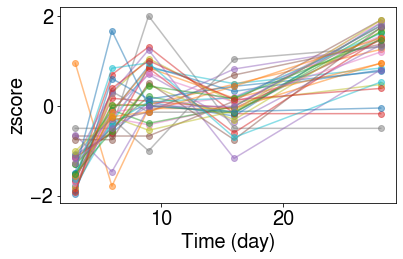

VARIANCE EXPLAINED: [0.72060153 0.16491934]


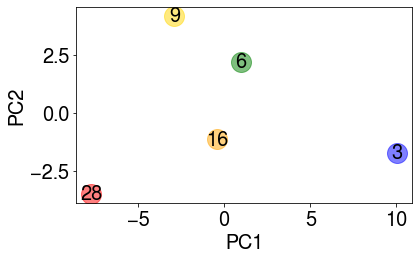

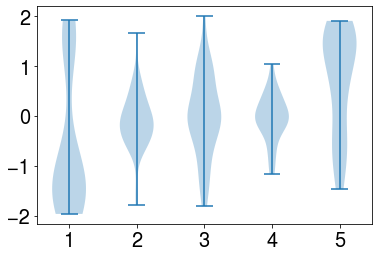

HIVEP3 25
['NECTIN1', 'UHRF1', 'NOP2', 'PPRC1', 'CILP2', 'QSOX2', 'IL1R1', 'CD3EAP', 'SHB', 'LMNB1', 'FJX1', 'CDC7', 'FAM83G', 'EPHB2', 'TEAD4', 'SLC2A6', 'APOL1', 'PTPRF', 'RHBDF2', 'PFAS', 'CSF1', 'WDR4', 'MYBBP1A', 'SEMA7A', 'LDLRAD3']


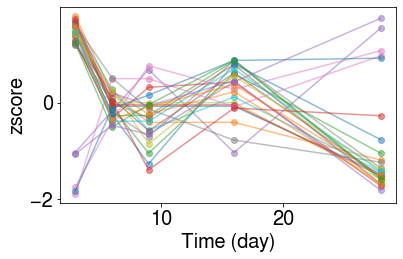

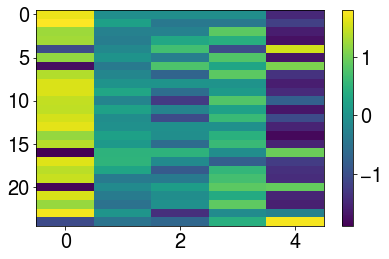

[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1]


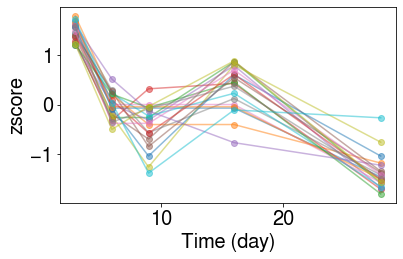

VARIANCE EXPLAINED: [0.85537983 0.0692769 ]


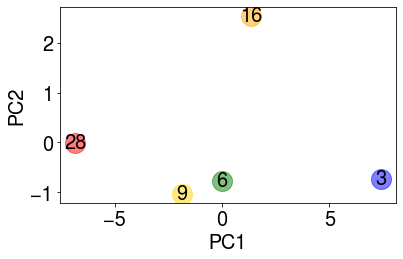

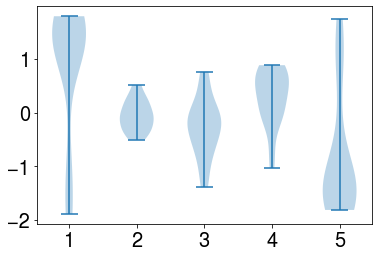

GATA5 44
['C1QTNF6', 'NCAPG', 'TNFRSF19', 'GNB3', 'EFEMP1', 'CFD', 'CHRDL1', 'PPARG', 'CLDN11', 'SAMD11', 'RASSF7', 'CYBRD1', 'FRMD5', 'RARRES2', 'LOXL2', 'TRIM46', 'SAA1', 'FBLN1', 'SERPING1', 'PODN', 'PPARGC1A', 'KCNT2', 'C3', 'HP', 'C7', 'SLIT3', 'PTK2B', 'VGLL4', 'PRR15', 'TIAM1', 'PCDH10', 'PKIG', 'RSPO1', 'SRPX', 'PLAT', 'PTPRF', 'MFAP4', 'MYLK', 'HMGA1', 'SAA2', 'CSF1', 'LUM', 'MYL3', 'CYP27A1']


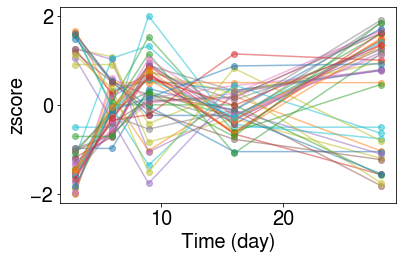

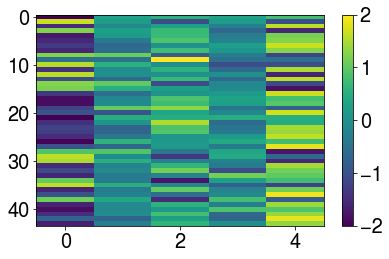

[0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0
 0 1 0 0 0 0 0]


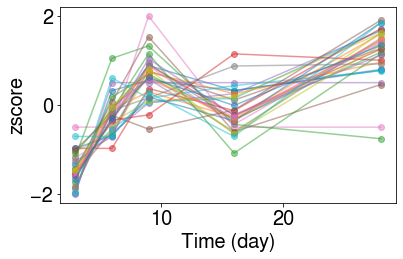

VARIANCE EXPLAINED: [0.77509644 0.12652366]


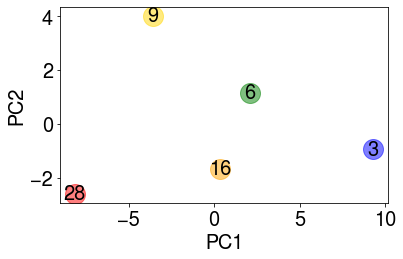

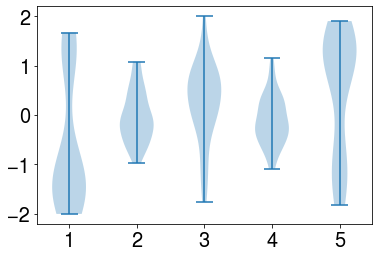

In [44]:
quality = []
for TF, row in df.head(5).iterrows():
    
    number_of_targets = int(row['TF targets DEGs / all TF targets'].split('/')[0])
    #if number_of_targets <= 4:
    print(TF, number_of_targets)

    # plot raw expression of all genes
    targets = row['Observed TF target DEGs'].split(', ')
    print(targets)

    regulon_expression = []
    for target in targets:
        regulon_expression.append(expression_trajectories[target])
    #print(regulon_expression)

    log2_regulon_expression = numpy.log2(regulon_expression)
    #print('log2 reg expression')
    #print(log2_regulon_expression)

    # zscores
    #print('zscores')
    zscores_regulon = scipy.stats.zscore(log2_regulon_expression, axis=1)
    #print(zscores_regulon)
    for gene_trajectory in zscores_regulon: 
        matplotlib.pyplot.plot(time_trajectory, gene_trajectory, 'o-', alpha=0.5)
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    # plot zscores as a matrix
    matplotlib.pyplot.imshow(zscores_regulon, aspect='auto')
    matplotlib.pyplot.colorbar()
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    
    # run some clustering
    #clustering = OPTICS(min_samples=5).fit_predict(zscores_regulon)
    #print(clustering, len(clustering))
    
    clustering = AgglomerativeClustering().fit_predict(zscores_regulon)
    print(clustering)
    
    for i in range(len(zscores_regulon)): 
        if clustering[i] == 0:
            matplotlib.pyplot.plot(time_trajectory, zscores_regulon[i], 'o-', alpha=0.5)
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    
    
    
    
    
    
    
    
    
    
    

    # run PCA
    pca = sklearn.decomposition.PCA(n_components=2)
    projection = pca.fit_transform(numpy.transpose(zscores_regulon))
    quality.append(pca.explained_variance_ratio_)
    print('VARIANCE EXPLAINED:', pca.explained_variance_ratio_)
    #print('projection', projection)
    
    
    for i in range(len(projection)):
        matplotlib.pyplot.plot(projection[i][0], projection[i][1], 'o', color=theColors[i], ms=20, alpha=0.5)
        matplotlib.pyplot.text(projection[i][0], projection[i][1], str(time_trajectory[i]), horizontalalignment='center', verticalalignment='center')
    matplotlib.pyplot.xlabel('PC1')
    matplotlib.pyplot.ylabel('PC2')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    matplotlib.pyplot.violinplot(zscores_regulon)
    matplotlib.pyplot.show()

In [ ]:
pca

In [ ]:
for element in zscores_regulon:
    print(element)